In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the training dataset
train_data = pd.read_csv('/content/drive/MyDrive/ML/cleaned_collision_train_data.csv')

# Separate features and target variable
X_train = train_data.drop('ACRS Report Type', axis=1)
y_train = train_data['ACRS Report Type']
# Prepare the test set with selected features
test_data = pd.read_csv('/content/drive/MyDrive/ML/cleaned_collision_test_data.csv')
X_test = test_data.drop('ACRS Report Type', axis=1)
y_test = test_data['ACRS Report Type']

In [ ]:
# Check column data types
print(X_train.dtypes)

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Route Type                 object
Road Name                  object
Cross-Street Name          object
Weather                    object
Surface Condition          object
Light                      object
Driver Substance Abuse     object
Speed Limit               float64
Vehicle Year                int64
Latitude                  float64
Longitude                 float64
Traffic Control            object
Collision Type             object
Driver At Fault            object
Vehicle Body Type          object
Vehicle Make               object
Vehicle Movement           object
Day of Week                 int64
Weekend                     int64
Time                        int64
Month                       int64
Year                        int64
Date in Month               int64
dtype: object
Non-numeric columns: Index(['Route Type', 'Road Name', 'Cross-Street Name', 'Weather',
       'Surface Condition', 'Light', 'Driver Substance Abuse',
       'Traffic Control', 'Collision Type', 'Driver At

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to non-numeric columns
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    # Handle unknown values in both train and test sets
    X_train[col] = label_encoder.fit_transform(X_train[col])

    # Get all unique values in both train and test sets
    all_values = list(set(X_train[col].unique()).union(set(X_test[col].unique())))

    # Fit the encoder on all unique values
    label_encoder.fit(all_values)

    # Transform both train and test sets
    X_train[col] = label_encoder.transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Initialize and train the decision tree
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train, y_train)

# Get feature importances
feature_importances = tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

                   Feature  Importance
9                 Latitude    0.113465
10               Longitude    0.112560
2        Cross-Street Name    0.101944
22           Date in Month    0.078759
1                Road Name    0.067021
19                    Time    0.062994
20                   Month    0.058035
21                    Year    0.046183
15            Vehicle Make    0.044990
8             Vehicle Year    0.044984
12          Collision Type    0.044238
17             Day of Week    0.043681
7              Speed Limit    0.032801
14       Vehicle Body Type    0.029181
16        Vehicle Movement    0.024705
3                  Weather    0.018478
5                    Light    0.016543
11         Traffic Control    0.015021
0               Route Type    0.013596
6   Driver Substance Abuse    0.010282
4        Surface Condition    0.009540
13         Driver At Fault    0.006001
18                 Weekend    0.004998


In [ ]:
# Filter the training and testing datasets to include only these features
X_train_top = X_train[['Latitude', 'Longitude', 'Date in Month', 'Cross-Street Name', 'Date in Month', 'Road Name', 'Time', 'Month']]

In [ ]:
# Encode the target variable if not already numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Apply SMOTE with specified parameters
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_top, y_train_encoded)

In [ ]:
import numpy as np

# Count the number of occurrences for each target class after SMOTE
unique_classes, counts = np.unique(y_train_balanced, return_counts=True)

# Map the encoded class back to its original label
class_labels = label_encoder.inverse_transform(unique_classes)

# Print the counts
print("Target Variable Distribution After SMOTE:")
for label, count in zip(class_labels, counts):
    print(f"{label}: {count}")

Target Variable Distribution After SMOTE:
fatal crash: 44993
injury crash: 44993
property damage crash: 44993


In [ ]:
# Train the Bagging model with balanced data
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=1
)

bagging_model.fit(X_train_balanced, y_train_balanced)

BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=1)

In [ ]:
X_test_top = X_test[['Latitude', 'Longitude', 'Date in Month', 'Cross-Street Name', 'Date in Month', 'Road Name', 'Time', 'Month']]
# Make predictions
y_pred = bagging_model.predict(X_test_top)

In [ ]:
# Decode predictions to original class labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)

In [ ]:
# Evaluate metrics
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
precision = precision_score(y_test_decoded, y_pred_decoded, average='weighted')
recall = recall_score(y_test_decoded, y_pred_decoded, average='weighted')
f_measure = f1_score(y_test_decoded, y_pred_decoded, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F-Measure: {f_measure:.4f}")

Accuracy: 0.5383
Precision: 0.5461
Recall: 0.5383
F-Measure: 0.5414


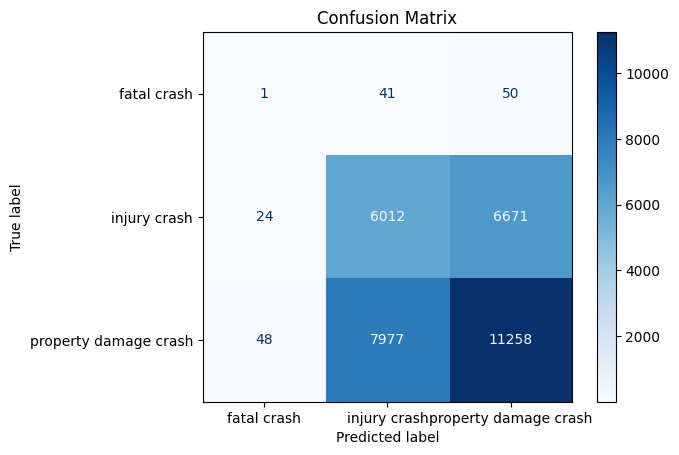

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Extract True Positive, True Negative, False Positive, False Negative for each class
# Note: This is for multi-class evaluation
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[    1    41    50]
 [   24  6012  6671]
 [   48  7977 11258]]


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Step 1: Get predicted probabilities for each class
y_pred_proba = bagging_model.predict_proba(X_test_top)

# Step 2: Binarize the true labels and predicted probabilities for multiclass ROC-AUC
# Assuming the target variable has multiple classes
classes = np.unique(y_test_encoded)  # Extract unique classes from the test set
y_test_binarized = label_binarize(y_test_encoded, classes=classes)

# Step 3: Calculate the ROC-AUC score for each class
roc_auc_scores = {}
for i, class_label in enumerate(classes):
    roc_auc_scores[class_label] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Step 4: Calculate the macro-average ROC-AUC score
macro_roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

# Step 5: Print the results
print("ROC-AUC Score per class:")
for class_label, score in roc_auc_scores.items():
    original_label = label_encoder.inverse_transform([class_label])[0]  # Decode to original label
    print(f"Class '{original_label}': {score:.4f}")

print(f"Macro-average ROC-AUC: {macro_roc_auc:.4f}")


ROC-AUC Score per class:
Class 'fatal crash': 0.5374
Class 'injury crash': 0.5388
Class 'property damage crash': 0.5397
Macro-average ROC-AUC: 0.5386
